<div style="text-align: right;">© 2025 Moses Boudourides. All Rights Reserved.</div>

## *instats* Workshop, March 9-12, 2025 
### https://instats.org/seminar/hypernetworks-in-theory-and-practice

# KEY METHODS OF HYPERGRAPH ANALYSIS
## Moses Boudourides

# I. BASICS OF HYPERGRAPHS

<span style="color:green">
    
### [1. Generation of Random Hypergraphs](#1)

### [2. Euler Plots of Hypergraphs](#2)

### [3. Bipartite Plots of Hypergraphs](#3)
    
### [4. Linear Hypergraphs](#4)

### [5. Uniform Hypergraphs](#5)

### [6. Degrees of Vertices and Hyperedges](#6)

### [7. Dual Hypergraphs](#7)

### [8. Incidence and Adjacency Matrices](#8)
    
### [9. Clique-Expanded Graphs of Hypergraphs](#9)

### [10. Line Graphs of Hypergraphs](#10)

### [11. Vertex Degree Preserving Adjacency Matrices of Hypergraphs](#11)    
        
</span>

In [1]:
import pandas as pd
import numpy as np
import random
import string
import itertools
lowercase_letters = list(string.ascii_lowercase)
uppercase_letters = list(string.ascii_uppercase)
import hypernetx as hnx
import networkx as nx
import pygraphviz
from networkx.drawing.nx_agraph import graphviz_layout
from networkx.drawing.nx_agraph import to_agraph
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
all_colors = list(mcolors.CSS4_COLORS.keys())
import pyvis
from pyvis.network import Network
from IPython.display import IFrame

In [2]:
def hypergraph_random_creator(vertices, hyperedge_names, m, minv, maxv, mw):
    """
    Creates a random hypergraph with custom vertex and hyperedge names.

    Parameters:
    - vertices (list of int or str): List of vertex names.
    - hyperedge_names (list of str): List of hyperedge names.
    - m (int): Number of hyperedges to create (must be <= length of hyperedge_names).
    - minv (int): Minimum number of nodes in a hyperedge.
    - maxv (int): Maximum number of nodes in a hyperedge (must be > minv).
    - mw (int): Determines the vertex format.
        - If mw == 0 or mw == 1, the function returns the hypergraph dictionary.
        - If mw > 1, vertices are represented as dictionaries with keys as vertex names and values as random integers between 1 and mw.

    Returns:
    - hg_d (dict): A dictionary representing the hypergraph, with sorted node sets.
    """
    # Check if m is valid
    if m > len(hyperedge_names):
        raise ValueError("m cannot be greater than the number of hyperedge names provided.")
    
    hg_d = {}
    for k in range(m):
        r = random.randint(minv, maxv)
        nodes = random.sample(vertices, r)
        sorted_nodes = sorted(nodes)

        # If mw > 1, modify vertices to be dictionaries
        if mw > 1:
            sorted_nodes = {node: random.randint(1, mw) for node in sorted_nodes}
        
        hg_d[hyperedge_names[k]] = sorted_nodes
        
    return hg_d

def dict2df(d, name1, name2):
    """
    Creates a dataframe from a dictionary with values as either lists or dictionaries with list values. 
    
    Parameters:
    - d (dict): the hypergraph data, with keys being hyperedges and values either lists of vertices
      or dictionaries with vertices as keys and associated weights as values.
    - name1: the name of hyperedges (dictionary keys)
    - name2: the name of vertices (elements of lists or dictionary keys)
    
    Returns:
    - A dataframe with either:
        - name1, corresponding to hyperedges
        - name2, corresponding to lists of vertices concatenated as strings separated by ', '
      OR
        - A weighted incidence matrix with rows as vertices and columns as hyperedges, 
          with the dictionary values as the weights.
    """
    # Check if the dictionary has dictionaries with lists of values
    if all(isinstance(v, dict) for v in d.values()) and all(isinstance(val, int) for sub in d.values() for val in sub.values()):
        # Handle case with dictionaries with integer values (weighted incidence matrix)
        # First, get all the unique vertices
        vertices = sorted(set(v for subdict in d.values() for v in subdict.keys()))
        
        # Prepare the incidence matrix data (rows: vertices, columns: hyperedges)
        incidence_matrix = []
        for vertex in vertices:
            row = []
            for hyperedge in d:
                row.append(d[hyperedge].get(vertex, 0))  # If vertex not in hyperedge, put 0
            incidence_matrix.append(row)

        # Create the dataframe for the weighted incidence matrix
        df = pd.DataFrame(incidence_matrix, index=vertices, columns=d.keys())
        
        print(d)
        return df 

    else:
        # Handle case with lists of vertices (original behavior)
        data = {
            name1: list(d.keys()),
            name2: [", ".join(map(str, d[key])) for key in d]  
        }
        df = pd.DataFrame(data)
        print(d)
        return df 

def hgp_hnx(d):
    """
    Prints a hypergraph dictionary and plots the Euler diagram of the hypergraph using HyperNetX.
    """
    H = hnx.Hypergraph(d)
    hnx.drawing.draw(H)
    plt.show()
    
def hgp_pyvis(d, name1, name2, vertex_size, hyperedge_size, vertex_color, hyperedge_colors, roundness, output_file="hypergraph.html"):
    """
    Visualizes a hypergraph using PyVis with labels on all nodes.

    Parameters:
    - d (dict): Hypergraph data, either with or without vertex weights.
                Example with weights: {'Group_A': {'Bob': 5, 'Jessy': 4}}
                Example without weights: {'Group_A': {'Bob', 'Jessy'}}
    - name1 (str): Label prefix for hyperedges (dictionary keys).
    - name2 (str): Label prefix for vertices (elements in dictionary values).
    - vertex_size (int): Size of vertices.
    - hyperedge_size (int): Size of hyperedges.
    - vertex_color (str): Color of vertices.
    - hyperedge_colors (list): Colors for hyperedges.
    - roundness (float): Curvature of edges.
    - output_file (str): Output HTML file (default: "hypergraph.html").
    """
    net = Network(notebook=True, height="800px", width="100%", bgcolor="#ffffff", font_color="black", cdn_resources="remote")
    G = nx.Graph()
    first_group_members = next(iter(d.values()))
    has_weights = isinstance(first_group_members, dict)
    for group, members in d.items():
        if has_weights:
            for member, weight in members.items():
                G.add_edge(group, member, weight=weight)  
        else:
            for member in members:
                G.add_edge(group, member, weight=1)  
    group_colors = {group: hyperedge_colors[idx % len(hyperedge_colors)] for idx, group in enumerate(d.keys())}
    for node in d.keys():
        net.add_node(node, size=hyperedge_size, color=group_colors[node], 
                     title=f"{name1}: {node}", label=str(node), font={"size": 20})
    all_vertices = set(G.nodes()) - set(d.keys())
    for node in all_vertices:
        net.add_node(node, size=vertex_size, color=vertex_color, 
                     title=f"{name2}: {node}", label=str(node), font={"size": 15})
    for source, target, data in G.edges(data=True):
        edge_color = group_colors[source] if source in d else group_colors[target]
        net.add_edge(source, target, 
                     width=data['weight'] if has_weights else 1, 
                     color=edge_color,
                     label=str(data['weight']) if has_weights else "",  
                     label_size=20,
                     label_align='center',
                     label_x_offset=0,
                     label_y_offset=0,
                     title=f"Weight: {data['weight']}" if has_weights else "",  
                     smooth={"type": "curvedCCW", "roundness": roundness})  
    net.toggle_physics(True)
    net.save_graph(output_file)

    return IFrame(src=output_file, width="100%", height="800px")

def is_linear(hypergraph):
    for e1, e2 in itertools.combinations(hypergraph, 2):
        if len(set(hypergraph[e1]) & set(hypergraph[e2])) > 1:
            return False  
    return True  

def is_k_uniform(hypergraph, k):
    for hyperedge, vertices in hypergraph.items():
        if len(vertices) != k:
            return False  
    return True

def is_connected(hypergraph):
    nodes = set([node for edge in hypergraph.values() for node in edge])
    visited = set()
    def dfs(node):
        visited.add(node)
        for edge in hypergraph.values():
            if node in edge:
                for neighbor in edge:
                    if neighbor not in visited:
                        dfs(neighbor)
    dfs(next(iter(nodes)))
    return visited == nodes

def clique_expansion(H):
    """Compute the weighted graph and its adjacency matrix of the clique expansion of a hypergraph given as a HypernetX object H."""
    G = nx.Graph()
    G.add_nodes_from(H.nodes)
    for edge, nodes in H.incidence_dict.items():
        nodes = list(nodes)
        for i in range(len(nodes)):
            for j in range(i + 1, len(nodes)):
                if G.has_edge(nodes[i], nodes[j]):
                    G[nodes[i]][nodes[j]]["weight"] += 1  
                else:
                    G.add_edge(nodes[i], nodes[j], weight=1)
    A = nx.to_numpy_array(G, nodelist=sorted(G.nodes()), weight="weight")
    return G, A

def vdpa_matrix(hypergraph):
    """
    Computes the Vertex Degree Preserving Adjacency Matrix (VDPA) for a hypergraph.

    Parameters:
    hypergraph (dict): A dictionary where keys are hyperedge IDs and values are lists of vertices in the hyperedge.

    Returns:
    numpy.ndarray: The VDPA matrix.
    list: The list of vertices in the hypergraph.
    """
    vertices = set()
    for hyperedge in hypergraph.values():
        vertices.update(hyperedge)
    vertices = sorted(vertices)  # Sort for consistent ordering
    num_vertices = len(vertices)
    vertex_to_index = {v: i for i, v in enumerate(vertices)}

    vdpa_matrix = np.zeros((num_vertices, num_vertices), dtype=float)
    for hyperedge in hypergraph.values():
        size_e = len(hyperedge)
        if size_e < 2:
            continue  # Skip hyperedges with fewer than 2 vertices
        for i in range(len(hyperedge)):
            for j in range(i + 1, len(hyperedge)):
                v1 = hyperedge[i]
                v2 = hyperedge[j]
                idx1 = vertex_to_index[v1]
                idx2 = vertex_to_index[v2]
                weight = 1.0 / (size_e - 1)
                vdpa_matrix[idx1, idx2] += weight
                vdpa_matrix[idx2, idx1] += weight  
    
    return vdpa_matrix, vertices

<a id='1'></a>
## <span style="color:green">1. Generation of Random Hypergraphs</span>

In [3]:
vertices=list(range(10))
# vertices=["Tom","John","Bob","Mary","Susan","Anne","Peter","Jessy","Don","Laura"]

# hyperedge_names = lowercase_letters[:10]
hyperedge_names = [f"e{i+1}" for i in range(10)]
# hyperedge_names=["Group_A","Group_B","Group_C","Group_D","Group_E"]

hg_d=hypergraph_random_creator(vertices, hyperedge_names, m=4, minv=1, maxv=6, mw=0)
df=dict2df(d=hg_d, name1='Hyperedge', name2='Vertices')
display(df.style.hide())

{'e1': [5, 6], 'e2': [0, 3, 4, 5, 7, 9], 'e3': [0, 6, 9], 'e4': [3, 6]}


Hyperedge,Vertices
e1,"5, 6"
e2,"0, 3, 4, 5, 7, 9"
e3,"0, 6, 9"
e4,"3, 6"


<a id='2'></a>
## <span style="color:green">2. Euler Plots of Hypergraphs</span>

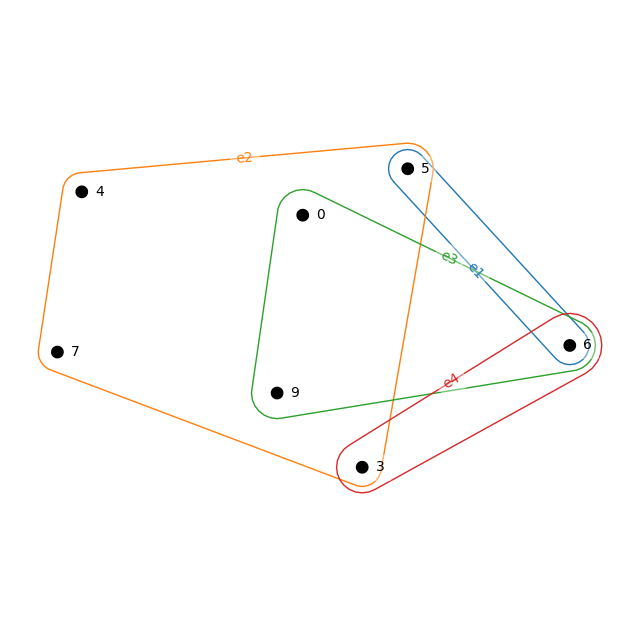

In [4]:
hgp_hnx(d=hg_d)

<a id='3'></a>
## <span style="color:green">3. Bipartite Plots of Hypergraphs</span>

In [5]:
d=hg_d
name1='Hyperedge'
name2='Vertices'
vertex_size=15 
hyperedge_size=5
vertex_color="yellow"
# hyperedge_colors=[c for c in random.sample(all_colors,4) if c!=vertex_color]
hyperedge_colors = ["cyan", "lime", "lightcoral", "violet"]
roundness=1
output_file="example.html"
hgp_pyvis(d, name1, name2, vertex_size, hyperedge_size, vertex_color, hyperedge_colors, roundness, output_file)

In [6]:
whg_d=hypergraph_random_creator(vertices, hyperedge_names, m=4, minv=1, maxv=6, mw=10)
wdf=dict2df(d=whg_d, name1='Hyperedge', name2='Vertices')
display(wdf.style.hide())

{'e1': {0: 7, 5: 6, 6: 5, 8: 9, 9: 9}, 'e2': {9: 5}, 'e3': {1: 7, 9: 10}, 'e4': {0: 6, 3: 8, 5: 10}}


e1,e2,e3,e4
7,0,0,6
0,0,7,0
0,0,0,8
6,0,0,10
5,0,0,0
9,0,0,0
9,5,10,0


In [16]:
d=whg_d
name1='Hyperedge'
name2='Vertices'
vertex_size=15 
hyperedge_size=5
vertex_color="yellow"
# hyperedge_colors=[c for c in random.sample(all_colors,4) if c!=vertex_color]
hyperedge_colors = ["cyan", "lime", "lightcoral", "violet"]
roundness=1
output_file="example.html"
hgp_pyvis(d, name1, name2, vertex_size, hyperedge_size, vertex_color, hyperedge_colors, roundness, output_file)

<a id='4'></a>
## <span style="color:green">4. Linear Hypergraphs</span>

{'e1': [0, 1, 2], 'e2': [2, 7], 'e3': [4, 5, 7, 8], 'e4': [7]}


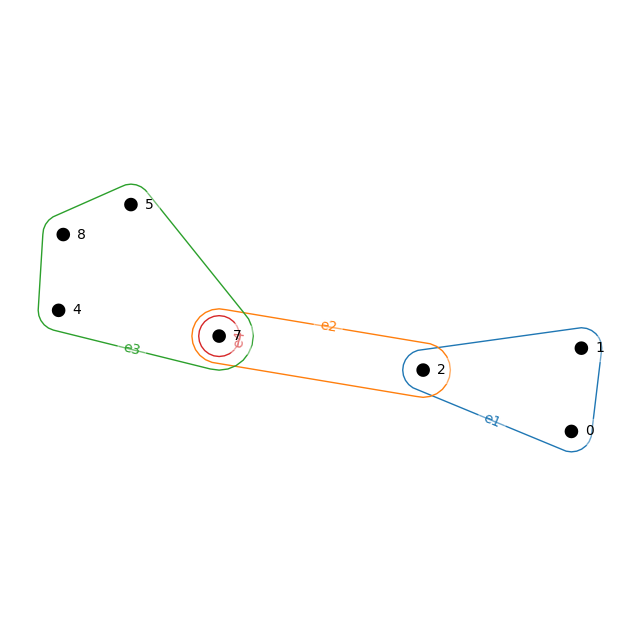

In [8]:
while True:
    hg_d=hypergraph_random_creator(vertices, hyperedge_names, m=4, minv=1, maxv=6, mw=0)
    if is_linear(hg_d):
        print(hg_d)
        break

# df=dict2df(d=hg_d, name1='Hyperedge', name2='Vertices')
# display(df.style.hide())
hgp_hnx(d=hg_d)

<a id='5'></a>
## <span style="color:green">5. Uniform Hypergraphs</span>

{'e1': [0, 6, 7, 8], 'e2': [1, 4, 5, 7], 'e3': [0, 2, 5, 9], 'e4': [0, 2, 7, 8]}


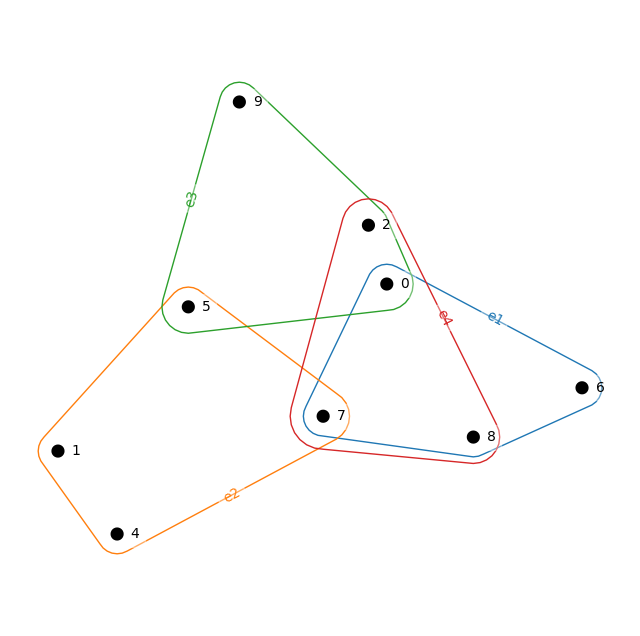

In [9]:
while True:
    hg_d=hypergraph_random_creator(vertices, hyperedge_names, m=4, minv=1, maxv=6, mw=0)
    if is_k_uniform(hg_d,k=4):
        print(hg_d)
        break
        
# df=dict2df(d=hg_d, name1='Hyperedge', name2='Vertices')
# display(df.style.hide())
hgp_hnx(d=hg_d)

<a id='6'></a>
## <span style="color:green">6. Degrees of Vertices and Hyperedges</span>

{'e1': [2, 3, 4, 6, 9], 'e2': [1, 9], 'e3': [6], 'e4': [3, 4, 5, 9], 'e5': [8]}


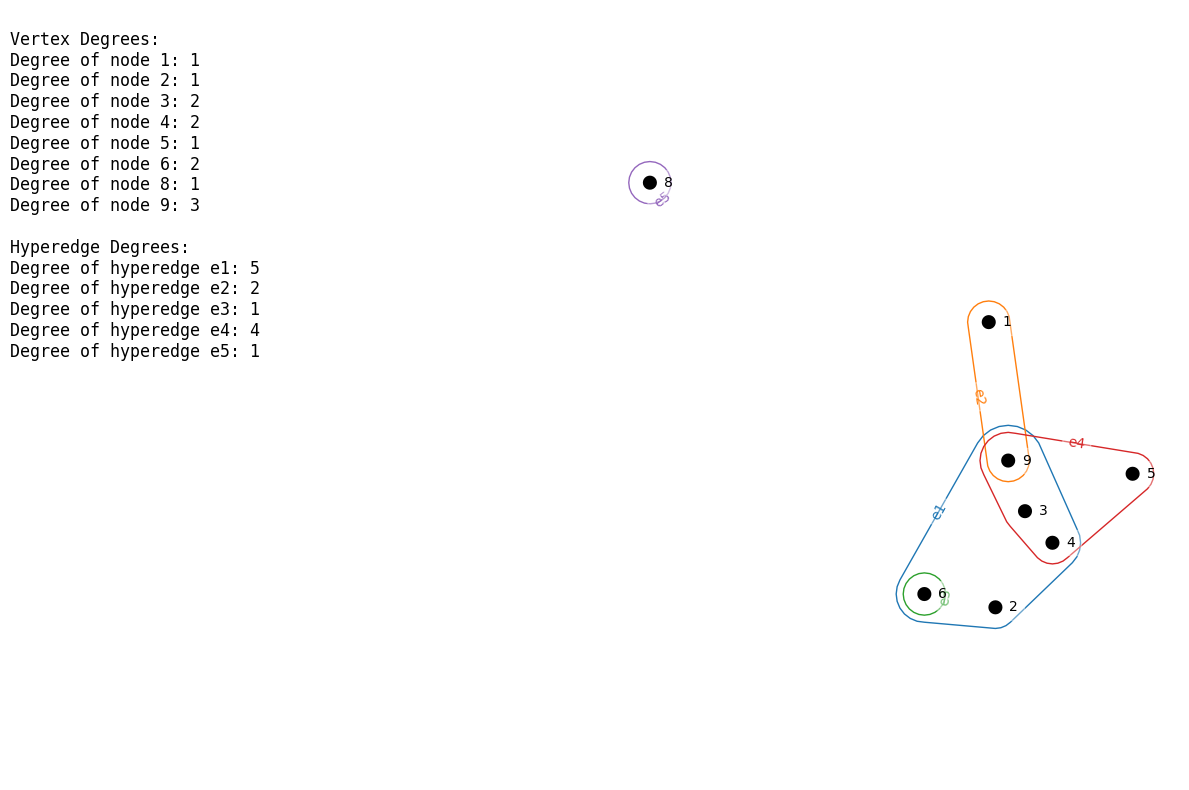

In [10]:
hg_d=hypergraph_random_creator(vertices, hyperedge_names, m=5, minv=1, maxv=6, mw=0)
H = hnx.Hypergraph(hg_d)
print(hg_d)

fig, axes = plt.subplots(1, 2, figsize=(12, 8))

text_output = []
text_output.append("\nVertex Degrees:")
for node in sorted(H.nodes):
    text_output.append(f"Degree of node {node}: {H.degree(node)}")
text_output.append("\nHyperedge Degrees:")
for edge in H.edges:
    text_output.append(f"Degree of hyperedge {edge}: {len(H.edges[edge])}")
axes[0].axis("off")  
text_display = "\n".join(text_output)
axes[0].text(0, 1, text_display, fontsize=12, verticalalignment="top", family="monospace")

hnx.draw(H, ax=axes[1])

plt.tight_layout()
plt.show()

<a id='7'></a>
## <span style="color:green">7. Dual Hypergraphs</span>

{'e1': [1, 4, 7, 8], 'e2': [5, 6, 7, 8], 'e3': [0, 4, 6, 7, 9], 'e4': [0, 1, 4, 5, 7], 'e5': [7]}
{1: ['e1', 'e4'], 4: ['e1', 'e3', 'e4'], 7: ['e1', 'e2', 'e3', 'e4', 'e5'], 8: ['e1', 'e2'], 5: ['e2', 'e4'], 6: ['e2', 'e3'], 0: ['e3', 'e4'], 9: ['e3']}


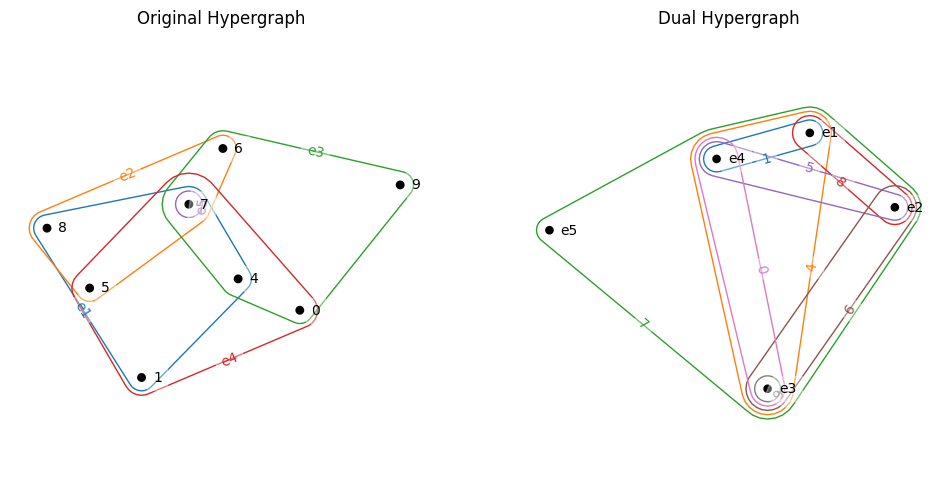

In [11]:
hg_d=hypergraph_random_creator(vertices, hyperedge_names, m=5, minv=1, maxv=6, mw=0)
H = hnx.Hypergraph(hg_d)
H_dual = H.dual() 
dual_dict = {int(node): list(H_dual.edges[node]) for node in H_dual.edges}
print(hg_d)
print(dual_dict)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
hnx.draw(H, ax=axes[0])
axes[0].set_title("Original Hypergraph")
hnx.draw(H_dual, ax=axes[1])
axes[1].set_title("Dual Hypergraph")
plt.show()

<a id='8'></a>
## <span style="color:green">8. Incidence and Adjacency Matrices</span>

{'e1': [7], 'e2': [1, 3, 6], 'e3': [4], 'e4': [1, 2, 3, 7, 8], 'e5': [5, 6]}


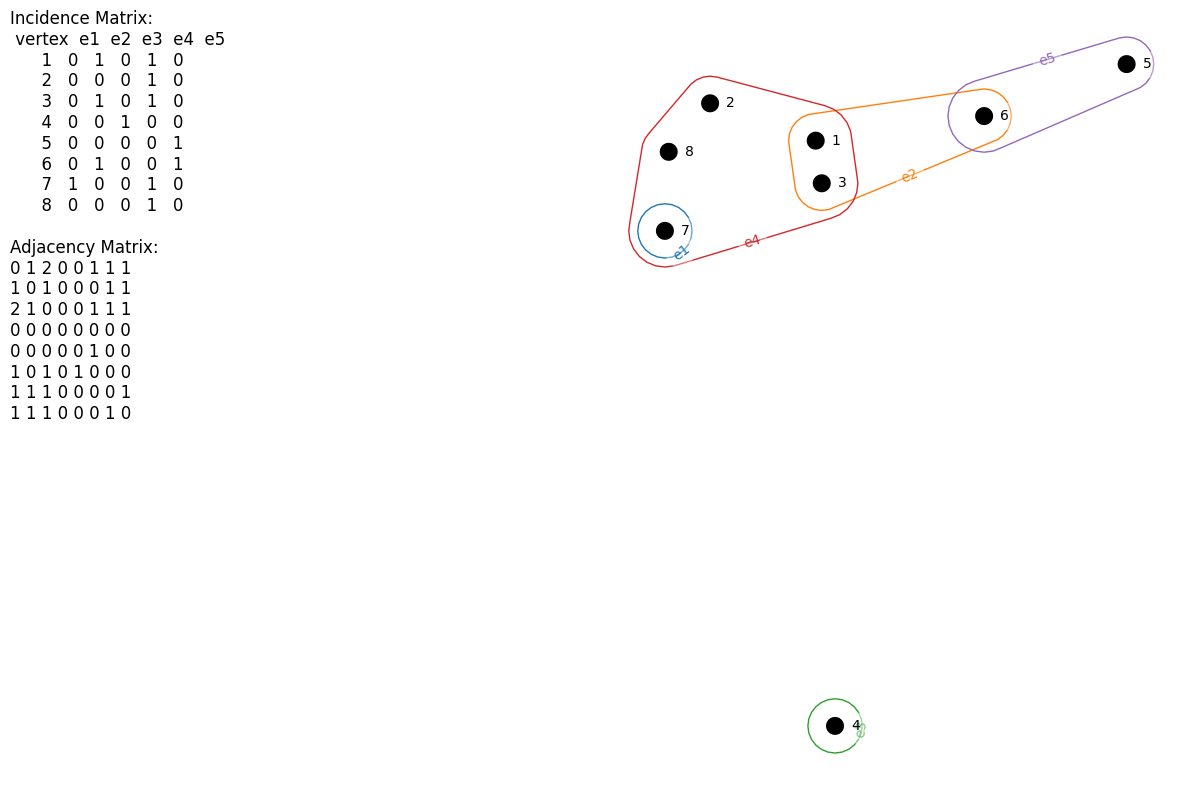

In [12]:
hg_d=hypergraph_random_creator(vertices, hyperedge_names, m=5, minv=1, maxv=6, mw=0)
print(hg_d)

H = hnx.Hypergraph(hg_d)
incidence_matrix = H.incidence_matrix().toarray()
A = incidence_matrix @ incidence_matrix.T  
np.fill_diagonal(A, 0) 
vertices = sorted(H.nodes)
incidence_df = pd.DataFrame(incidence_matrix, index=vertices, columns=H.edges)
incidence_df.insert(0, "vertex", incidence_df.index)
adjacency_df = pd.DataFrame(A, index=vertices, columns=vertices)  

fig, axes = plt.subplots(1, 2, figsize=(12, 8))

left_text = "Incidence Matrix:\n"
left_text += incidence_df.to_string(index=False) + "\n\n"
left_text += "Adjacency Matrix:\n"
left_text += adjacency_df.to_string(index=False,header=False) + "\n"
axes[0].axis('off')
axes[0].text(0, 1, left_text, fontsize=12, va='top', wrap=True)

hnx.draw(H, ax=axes[1])
axes[1].axis('off')

plt.tight_layout()
plt.show()

<a id='9'></a>
## <span style="color:green">9. Clique-Expanded Graphs of Hypergraphs</span>

{'e1': [1, 2, 5, 6, 7], 'e2': [2, 3, 4, 5, 6, 8], 'e3': [1, 3, 4, 5], 'e4': [1, 3, 5]}


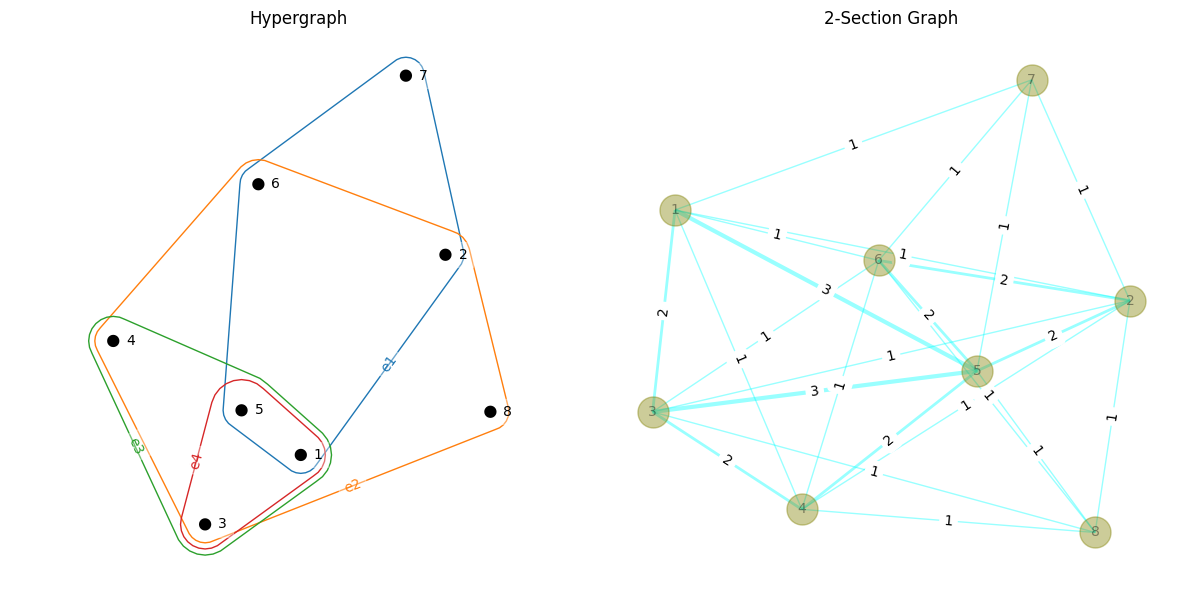

In [13]:
while True:
    hg_d=hypergraph_random_creator(vertices, hyperedge_names, m=4, minv=1, maxv=6, mw=0)
    if is_connected(hg_d) and not is_linear(hg_d):
        break
hg_d = {edge: [node.item() for node in nodes] for edge, nodes in hg_d.items()}
print(hg_d)
H = hnx.Hypergraph(hg_d)
G,A=clique_expansion(H)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
hnx.draw(H, ax=axes[0])
axes[0].set_title("Hypergraph")

pos = pos=graphviz_layout(G) # nx.spring_layout(G)  
edges = G.edges(data=True)
edge_labels = {(e1, e2): d["weight"] for e1, e2, d in edges}
nx.draw(G, pos, ax=axes[1], with_labels=True, node_size=500, font_size=10, edge_color="cyan", width=[d["weight"] for _, _, d in edges], node_color="olive", alpha=0.4)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=axes[1], font_size=10)
axes[1].set_title("2-Section Graph")

plt.tight_layout()
plt.show()

<a id='10'></a>
## <span style="color:green">10. Line Graphs of Hypergraphs</span>

{'e1': [2, 4, 6, 7, 8], 'e2': [3, 5], 'e3': [1, 2, 3, 5], 'e4': [1, 3, 4], 'e5': [1, 2, 5, 6, 7, 8]}


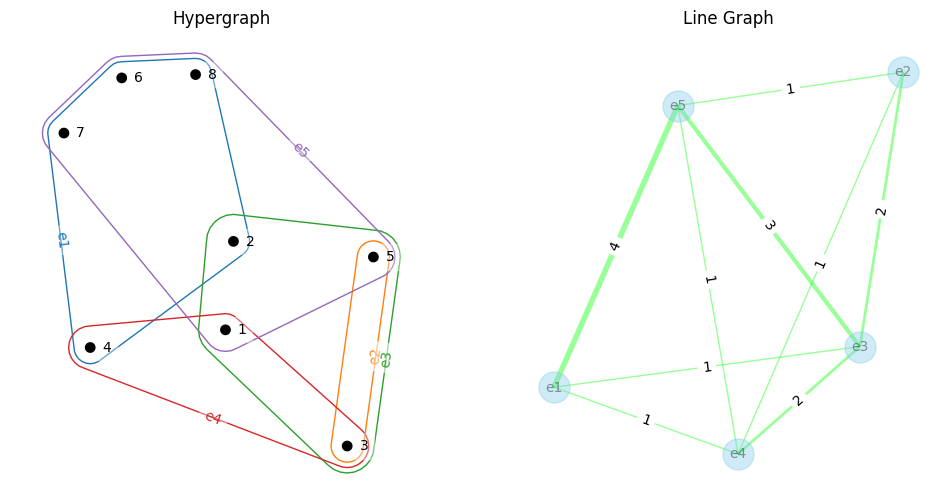

In [14]:
hg_d=hypergraph_random_creator(vertices, hyperedge_names, m=5, minv=1, maxv=6, mw=0)
hg_d = {k: [int(v) for v in vals] for k, vals in hg_d.items()}
print(hg_d)
H = hnx.Hypergraph(hg_d)  
H_line = nx.Graph()
hyperedges = list(hg_d.keys())
H_line.add_nodes_from(hyperedges)
for i in range(len(hyperedges)):
    for j in range(i + 1, len(hyperedges)):
        e1, e2 = hyperedges[i], hyperedges[j]
        shared_nodes = len(set(hg_d[e1]) & set(hg_d[e2]))  # Count shared nodes
        if shared_nodes > 0:
            H_line.add_edge(e1, e2, weight=shared_nodes)
            
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
hnx.draw(H, ax=axes[0])
axes[0].set_title("Hypergraph")

pos = graphviz_layout(H_line) # nx.spring_layout(H_line)  
edges = H_line.edges(data=True)
edge_labels = {(e1, e2): d["weight"] for e1, e2, d in edges}
nx.draw(H_line, pos, ax=axes[1], with_labels=True, node_size=500, font_size=10, edge_color="lime", width=[d["weight"] for _, _, d in edges], node_color="skyblue", alpha=0.4)
nx.draw_networkx_edge_labels(H_line, pos, edge_labels=edge_labels, ax=axes[1], font_size=10)
axes[1].set_title("Line Graph")
plt.show()

<a id='11'></a>
## <span style="color:green">11. Vertex Degree Preserving Adjacency Matrices of Hypergraphs</span>

{'e1': [3, 4, 5, 7], 'e2': [2, 4, 6, 8], 'e3': [2, 3, 4, 5, 6], 'e4': [1, 3, 6, 8], 'e5': [1, 2, 3, 6, 7, 8]}


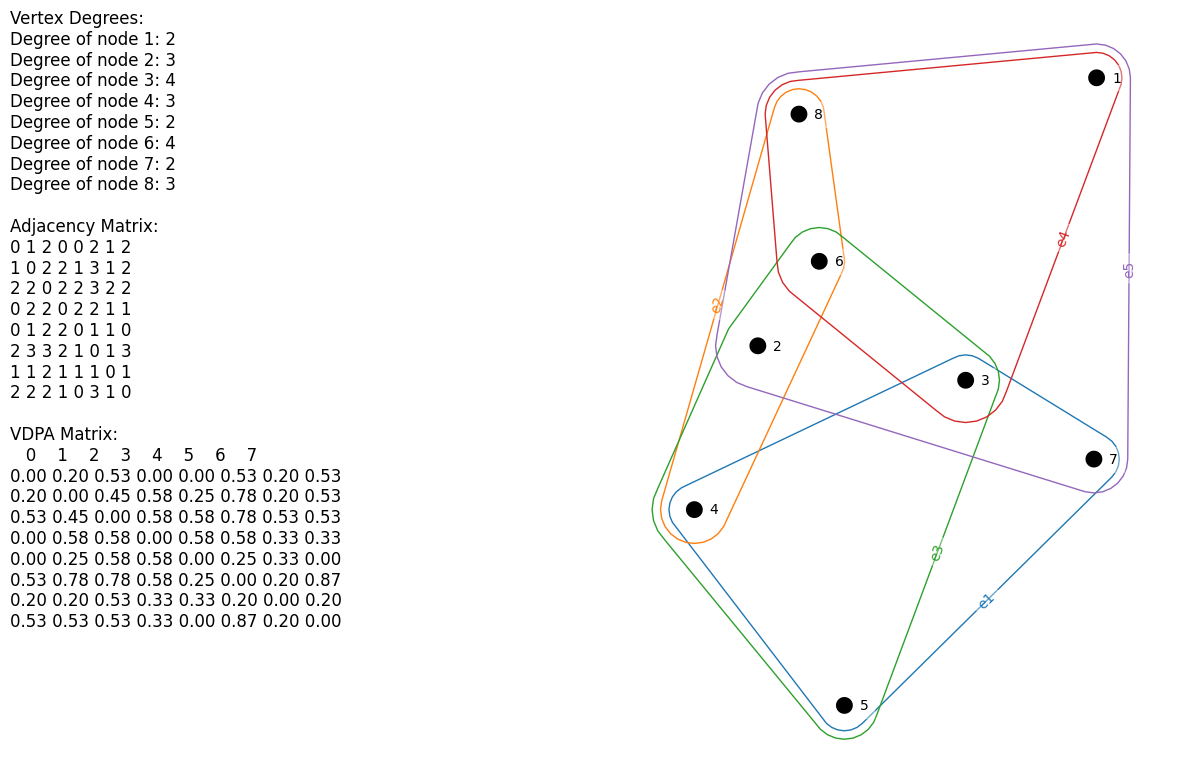

In [15]:
hg_d=hypergraph_random_creator(vertices, hyperedge_names, m=5, minv=1, maxv=6, mw=0)
hg_d = {k: [int(v) for v in vals] for k, vals in hg_d.items()}
print(hg_d)

H = hnx.Hypergraph(hg_d)
incidence_matrix = H.incidence_matrix().toarray()
A = incidence_matrix @ incidence_matrix.T  
np.fill_diagonal(A, 0) 
vertices = sorted(H.nodes)
vdpa, vertices = vdpa_matrix(hg_d)
vdpa_df = pd.DataFrame(vdpa).round(2)

left_text = "Vertex Degrees:\n"
for node in sorted(H.nodes):
    left_text += f"Degree of node {node}: {H.degree(node)}\n"
left_text += "\nAdjacency Matrix:\n"
left_text += pd.DataFrame(A, index=vertices, columns=vertices).to_string(index=False, header=False) + "\n\n"
left_text += "VDPA Matrix:\n"
left_text += vdpa_df.to_string(index=False)

fig, axes = plt.subplots(1, 2, figsize=(12, 8))

axes[0].axis('off')
axes[0].text(0, 1, left_text, fontsize=12, va='top', wrap=True)

hnx.draw(H, ax=axes[1])
axes[1].axis('off')

plt.tight_layout()
plt.show()